In [2]:
import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.26.0


# 1) ESML - TRAIN Classification, TITANIC model, and DEPLOY with predict_proba scoring

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [3]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.active_model = 10
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.inference_mode = False

unregister_all_datasets=False
if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose

p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Inference version: 1

 - ds01_titanic
projects/project002/10_titanic_model_clas/train/ds01_titanic/in/dev/2021/01/01/
projects/project002/10_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds01_titanic/out/silver/dev/

 - ds02_haircolor
projects/project002/10_titanic_model_clas/train/ds02_haircolor/in/dev/2021/01/01/
projects/project002/10_titanic_model_clas/train/ds02_haircolor/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds02_haircolor/out/silver/dev/

 - ds03_housing
projects/project002/10_titanic_model_clas/train/ds03_housing/in/dev/2021/01/01/
projects/project002/10_titanic_model_clas/train/ds03_housing/out/bronze/dev/
projects/project002/10_titanic_model_clas/train/ds03_housing/out/silver/dev/

 - ds04_lightsaber
projects/project002/10_titanic_model_clas/train/ds04_lightsaber/in/dev/2021/01/01/
projects/project002/10_titani

In [4]:
def test_feature_engieering():
    # R&D purpose: Try some data wrangling here...we will later incorporate this in an Azure ML Pipeline, as "steps"
    esml_dataset = p.DatasetByName("ds01_titanic") 
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    df_bronze.columns = df_bronze.columns.str.replace("[/]", "_") # Rename werid column names

    df_silver = p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    esml_dataset2 = p.DatasetByName("ds02_haircolor")
    esml_dataset3 = p.DatasetByName("ds03_housing")
    esml_dataset4 = p.DatasetByName("ds04_lightsaber")

    p.save_silver(esml_dataset2,esml_dataset2.Bronze.to_pandas_dataframe()) #Bronze -> Silver
    p.save_silver(esml_dataset3,esml_dataset3.Bronze.to_pandas_dataframe()) #Bronze -> Silver
    p.save_silver(esml_dataset4,esml_dataset4.Bronze.to_pandas_dataframe()) #Bronze -> Silver

    gold = p.save_gold(esml_dataset.Silver.to_pandas_dataframe())  #Silver -> Gold STEP
    return gold

In [5]:
datastore = None
gold = None
gold_train = None
try:
    datastore = p.connect_to_lake()
    gold = p.Gold
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

Using GEN2 as Datastore
Not 1st time. We have data mapped already. Now connected to LAKE


In [6]:
p.Gold.to_pandas_dataframe().head()

,Survived,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

# 3) Production purpose: "once and only once": Wrap code
- 3 Callers: MLOps, AMLPipeline, and this notebook

In [7]:
import repackage
repackage.add("../2_A_aml_pipeline/4_inference/batch/M10/your_code/")
from your_custom_code import M01In2GoldProcessor

#p.init()
esml_dataset1 = p.DatasetByName("ds01_titanic") # Get dataset 1
df_bronze = esml_dataset1.Bronze.to_pandas_dataframe()
silver1 = p.save_silver(esml_dataset1,df_bronze) #Bronze -> Silver

esml_dataset2 = p.DatasetByName("ds02_haircolor") # Get dataset 2
df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
silver2 = p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

df1 = M01In2GoldProcessor().M01_ds01_process_in2silver(silver1.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds01...py"
df2 = M01In2GoldProcessor().M01_ds02_process_in2silver(silver2.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds02...py"

merged_gold = M01In2GoldProcessor().M01_merge_silvers(df1,df2) # # You can then copy this statement in your pipeline-step "silver_merged_2_gold.py"

In [8]:
merged_gold.head()

,Survived,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [9]:
label = p.active_model["label"]
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # Auto-register datasets in AZURE (GOLD_TRAIN | GOLD_VALIDATE | GOLD_TEST)   

In [10]:
label

'Survived'

# 2) `ESML` Train model in `5 codelines`

In [11]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

automl_config = AutoMLConfig(task = 'classification', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_classification.AUC, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.922', # DEMO purpose (0.308 for diabetes regression, 0.6 for classification titanic)
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False # Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster prj02-m10-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = prj02-m10-dev
Experiment name: 10_titanic_model_clas
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on prj02-m10-dev with default configuration
Runni

Experiment,Id,Type,Status,Details Page,Docs Page
10_titanic_model_clas,AutoML_06e98976-b075-4759-b03a-76e9c0961bb3,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


KeyboardInterrupt: 

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

## 2b) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [ ]:
from baselayer_azure_ml import AutoMLFactory
target_env = p.dev_test_prod #"dev", test, prod  = Target environment. Does Model A score better than Model B?
print("SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD \n")

promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env)  

# To override (option 1) "definition of BETTER" - Adjust settings/model_settings.json to define & adjust "what is best in my use case"
# To override (option 2) - just Register whatever model you see is the best. "latest registered = best"
# - After, if you want to use AutoMLFactory(p).register_active_model(target_env), need to edit 'run_id' 'registered_model_version' in  /project_specifics/dev_test_prod/train/.../automl_active_model_dev.json

# To override (option 3) - inject your own LAMBDA function "your definition iof best" 
#my_def_of_what_model_is_better = lambda sklearn_model_new,sklearn_model_current : (sklearn_model_new > sklearn_model_current)
#promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env,my_def_of_what_model_is_better)

print("New Model: {} in environment {}".format(m1_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(m2_name,target_env))

if (promote and p.dev_test_prod == target_env): # Can register a model in same workspace (test->test) - need to retrain if going from dev->test (but copy from test->prod)
    AutoMLFactory(p).register_active_model(target_env)


SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD 

Loading AutoML config settings from: dev
targe=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)



Package:azureml-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0
Package:azur

TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
target_best_run_id AutoML_ce3e2fee-d26c-45f3-bea5-8bbef7bb6546


Package:azureml-automl-runtime, training version:1.33.0, current version:1.26.0
Package:azureml-core, training version:1.33.0, current version:1.26.0
Package:azureml-dataprep, training version:2.20.1, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.18.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.33.0, current version:1.26.0
Package:azureml-defaults, training version:1.33.0, current version:1.26.0
Package:azureml-interpret, training version:1.33.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.33.0, current version:1.26.0
Package:azureml-telemetry, training version:1.33.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.33.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.33.0, current version:1.26.0
Package:azureml-responsibleai, training version:1.33.0


New trained model & cached RUN, has TASK_TYPE: classification and Best_Run_id: AutoML_7e3ddc93-d7a6-4989-87d2-b538e6a24281_7
Target model & RUN, in Azure ML Studio workspace to compare with, has TASK_TYPE: regression and Best_Run_id: 
This is the first model. No target to compare with, hence we will PROMOTE
New Model: AutoML7e3ddc93d7 in environment dev
Existing Model: AutoMLce3e2feed0 in environment dev
Loading AutoML config settings from: dev
Loading AutoML config settings from: dev


model.version 1
Model name AutoML7e3ddc93d7 is registered.


# TEST SET SCORING

# Test-set: Ensure we have a TEST_SET splitted

In [ ]:
label = p.active_model["label"]
try:
    p.GoldTest.name
except: 
    p.connect_to_lake()
    train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label)

'dev'

### NOW we can calcualate scoring on TEST_SET

found model via REMOTE FILTER: Experiment TAGS: model name and version


Package:azureml-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0
Package:azur

Replacing tag run_id -> AutoML_7e3ddc93-d7a6-4989-87d2-b538e6a24281 with run_id -> AutoML_7e3ddc93-d7a6-4989-87d2-b538e6a24281
Replacing tag model_name -> AutoML7e3ddc93d7 with model_name -> AutoML7e3ddc93d7
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 10_titanic_model_clas with experiment_name -> 10_titanic_model_clas
Replacing tag test_set_ROC_AUC -> 0.853905 with test_set_ROC_AUC -> 0.853905
Replacing tag test_set_Accuracy -> 0.837079 with test_set_Accuracy -> 0.837079
Replacing tag test_set_F1_Score -> 0.794326 with test_set_F1_Score -> 0.794326
Replacing tag test_set_Precision -> 0.721128 with test_set_Precision -> 0.721128
Replacing tag test_set_Recall -> 0.777778 with test_set_Recall -> 0.777778
Replacing tag test_set_Matthews_Correlation -> 0.659953 with test_set_Matthews_Correlation

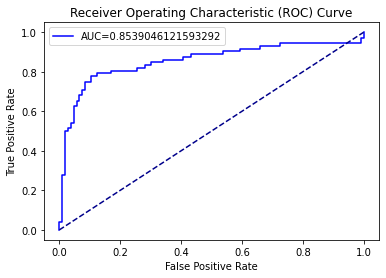

In [12]:
from baselayer_azure_ml import ESMLTestScoringFactory
label = p.active_model["label"]

auc,accuracy,f1, precision,recall,matrix,matthews, plt = ESMLTestScoringFactory(p).get_test_scoring_7_classification(label)

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Matchews correlation:")
print(matthews)
print()
print("Confusion Matrix:")
print(matrix)


# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

## 3b) DEPLOY TEST with ESML `2 lines of code`

X_test, y_test, tags = p.get_gold_validate_Xy() 
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

df = p.call_webservice(p.ws, X_test,caller_id) 
df.head()

# 3b) ESML `DEPLOY - custom scoring` file - predict proba

In [26]:
inference_config_to_override_and_inject, model, best_run = p.get_active_model_inference_config(p.ws) # 1) You can override this scoring_script - get a baseline, then modify...
my_custom_script_instead = 'scoring_file_dev_M01_titanic.py'
inference_config_to_override_and_inject.entry_script = 'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\' + my_custom_script_instead

inference_config_to_override_and_inject.entry_script # Verify path

Loading AutoML config settings from: dev
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, c

'c:\\Users\\jostrm\\OneDrive - Microsoft\\0_GIT\\2_My\\github\\azure-enterprise-scale-ml\\settings\\project_specific\\model\\dev_test_prod\\train\\automl\\scoring_file_dev_M01_titanic.py'

In [27]:
# DEPLOY with custom InferenceConfig (custom scoring script)
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config_to_override_and_inject, True) #2) (model,inference_config, overwrite_endpoint=True,deployment_config=None):

Deploying model: AutoML8f39095707 with verison: 1 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m01-dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since not supported) for environment dev
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-21 09:37:11+02:00 Creating Container Registry if not exists.
2021-06-21

# INFERENCE - Scenario "Caller/Client"

## 1) Get MockData - Get some TEST-DATA via ESMLProject...the GoldTest

In [28]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [29]:
label = p.active_model["label"]
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    #print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")
# #X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)

## 2) Call AKS Webservice in 3 ways (A,B,C)
- A) Also let AKS save data to lake
- B) Use the ESML helper method (fetched keys from vault AND joins result + features)
- C) Simulate "Rest only" - No ESML dependency 
    - No ESML meaning: Fetch keys by your own from vault + join/format JSON yourself + save data yourself to lake)

### Alt 1 - ESML.call_webservice, `get PANDAS joined` dataframe
#### `Also saves to LAKE, automatically`

In [33]:
#p.lakestore = p.set_lake_as_datastore(p.ws) # For AutoSave - this i NOT needed if p.init() is done...which usually is the case.
p.call_webservice(p.ws, to_score,"caller_id").head() # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_caller_id.parquet'
Saved SCORED data in LAKE, as file 'scored_caller_id.parquet'


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78


### Alt 2 - use compute factory, control to `get JSON back` instead of PANDAS. 
#### `No saving to LAKE`

In [34]:
result, model_version_used = p.compute_factory.call_webservice(to_score,False,False) # (X_test, firstRowOnly=True,pandas_result=True, api_uri=None,api_key="auto from keyvault")
df_res = pd.read_json(result)
to_score.join(df_res) # Need to join the FEATURES yourself, post webservice call (simulate no ESML dependancy in caller)

Note: Fetching keys automatically via workspace keyvault.


,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78
...,...,...,...,...,...,...,...,...,...
173,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.08
174,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.79
175,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.04
176,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.35


### Alt 3 - Simulate client witn no ESML SDK, just using the "scoring endpoint". 
- Just JSON result (No ESML dependancy `get JSON back`)
#### `No saving to LAKE` and `no JOIN` 

In [35]:
from baselayer_azure_ml import ComputeFactory
import json
keyvault = p.ws.get_default_keyvault() # Authentica to your Azure ML workspace (ws)
api_uri = keyvault.get_secret(name='esml-dev-p02-m10-api') 
api_key = keyvault.get_secret(name='esml-dev-p02-m10-apisecret') # DEV + Titanic

#api_uri = keyvault.get_secret(name='esml-test-p02-m10-api') # TEST + Titanic
#api_key = keyvault.get_secret(name='esml-test-p02-m10-apisecret')

result_json = ComputeFactory.call_webservice_static(to_score, api_uri,api_key,firstRowOnly=False) # Simulate "REST call" (no ESML dependancy, just a wrapper for a pytnon REST call)
res_dict = json.loads(result_json.text) # json -> dictionary
df_res = pd.read_json(res_dict) # dictionary -> pandas
all_result = X_test.join(df_res) # features + result
all_result

Relying on you having the keys...


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,result,probability
0,1,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0,0.02
1,1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0,0.02
2,0,3,Mr. Edward Willey,male,21.00,0,0,7.55,0,0.22
3,1,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1,0.92
4,1,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1,0.78
...,...,...,...,...,...,...,...,...,...,...
173,1,3,Mr. Albert Johan Moss,male,29.00,0,0,7.78,0,0.08
174,1,2,Mrs. (Elizabeth Anne Maidment) Mellinger,female,41.00,0,1,19.50,1,0.79
175,0,2,Mr. John William Gill,male,24.00,0,0,13.00,0,0.04
176,0,1,Mr. Mark Fortune,male,64.00,1,4,263.00,0,0.35


In [36]:
# And....you need to save the data yourself to the lake, at this location
to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
print("Save your data here, if you want to have ADF WriteBack function")
print()
print(scored_folder)
print()
print("Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead ")

Save your data here, if you want to have ADF WriteBack function

projects/project002/01_titanic_model_clas/inference/1/scored/dev/2021_06_21/5f410d5b1ad64e14a9613ff7a7de2e14/

Note: Last folder, UUID folder, should represent a 'unique scoring' for a day, but can be injected. Example: if we want a customerGUID instead 


# END

# EXTRA - more about `AutoLake Paths`

In [37]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject
p = ESMLProject() 
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

In [38]:
p.inference_mode = True # This flag will "change the paths", from TRAIN folder to INFERENCE folder-structure

print("")
print("INFERENCE")
print("")

for d in p.Datasets:
    print(d.Name)
    print("IN", d.InPath)
    print("Bronze", d.BronzePath)
    print("Silver", d.SilverPath)

to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path(p.date_scoring_folder)
print("Gold", to_score_folder, "  ...uuid folder, is to be able to have multiple unique scorings, same datetime")

print("")
print("TRAIN")
print("")

p.inference_mode = False # This flag will "change the paths"

for d in p.Datasets:
    print(d.Name)
    print("IN", d.InPath)
    print("Bronze", d.BronzePath)
    print("Silver", d.SilverPath)

print("Gold", p.GoldPath)


INFERENCE

ds01_titanic
IN projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/in/dev/2021/06/08/
Bronze projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/out/bronze/dev/
Silver projects/project002/01_titanic_model_clas/inference/1/ds01_titanic/out/silver/dev/
Gold projects/project002/01_titanic_model_clas/inference/1/gold/dev/2021_06_08/3d74a4a26efc404b930b1cbaa9a47f5c/   ...uuid folder, is to be able to have multiple unique scorings, same datetime

TRAIN

ds01_titanic
IN projects/project002/01_titanic_model_clas/train/ds01_titanic/in/dev/2021/01/01/
Bronze projects/project002/01_titanic_model_clas/train/ds01_titanic/out/bronze/dev/
Silver projects/project002/01_titanic_model_clas/train/ds01_titanic/out/silver/dev/
Gold projects/project002/01_titanic_model_clas/train/gold/dev/
